In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()

## Preprocessing data

#### Hourly data

In [2]:
load_path = 'processed_data/data_2006_2023.csv'

In [3]:
load_data = pd.read_csv(load_path)

In [4]:
## to make sure that data is stationary

# Check for stationarity using Augmented Dickey-Fuller test
def adf_test(series):
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    if result[1] < 0.05:
        print("Data is stationary")
    else:
        print("Data is NOT stationary")

In [5]:
adf_test(load_data["loadConsumption"])

ADF Statistic: -27.204566436886566
p-value: 0.0
Data is stationary


In [6]:
load_data["datetime"] = pd.to_datetime(load_data["datetime"])

In [7]:
load_data

,loadConsumption,date,datetime,Hour,Year
0,10215.0000,2006-01-01,2005-12-31 23:00:00,0,2006
1,9979.0000,2006-01-01,2006-01-01 00:00:00,1,2006
2,9460.0000,2006-01-01,2006-01-01 01:00:00,2,2006
3,8833.0000,2006-01-01,2006-01-01 02:00:00,3,2006
4,8525.0000,2006-01-01,2006-01-01 03:00:00,4,2006
...,...,...,...,...,...
157767,12673.4650,2023-12-31,2023-12-31 19:00:00,20,2023
157768,12366.1950,2023-12-31,2023-12-31 20:00:00,21,2023
157769,12143.1775,2023-12-31,2023-12-31 21:00:00,22,2023
157770,11993.1200,2023-12-31,2023-12-31 22:00:00,23,2023


In [8]:
load_data.set_index("datetime", inplace=True)

In [9]:
avg_hourly_load = load_data.groupby(['Year', 'Hour'])['loadConsumption'].mean().reset_index()

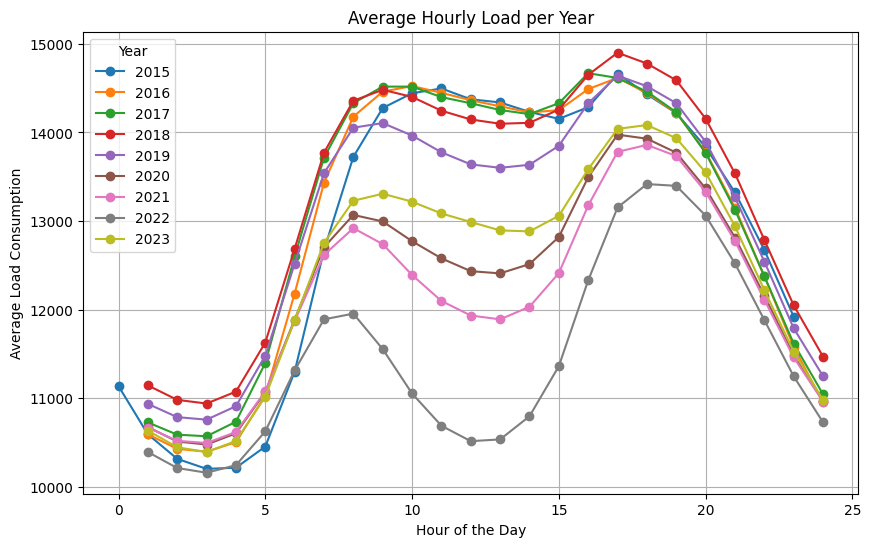

In [10]:
# Set the figure size for better readability
plt.figure(figsize=(10, 6))

# Loop through each unique year and plot its average load by hour
for year in avg_hourly_load['Year'].unique():
    if year >= 2015:  # Filter years from 2015 onwards
        subset = avg_hourly_load[avg_hourly_load['Year'] == year]
        plt.plot(subset['Hour'], subset['loadConsumption'], marker='o', label=str(year))
# Label the axes and add a title
plt.xlabel('Hour of the Day')
plt.ylabel('Average Load Consumption')
plt.title('Average Hourly Load per Year')
plt.legend(title='Year')
plt.grid(True)

# Save the plot as a PNG image
plt.savefig('plots/average_hourly_load_per_year.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

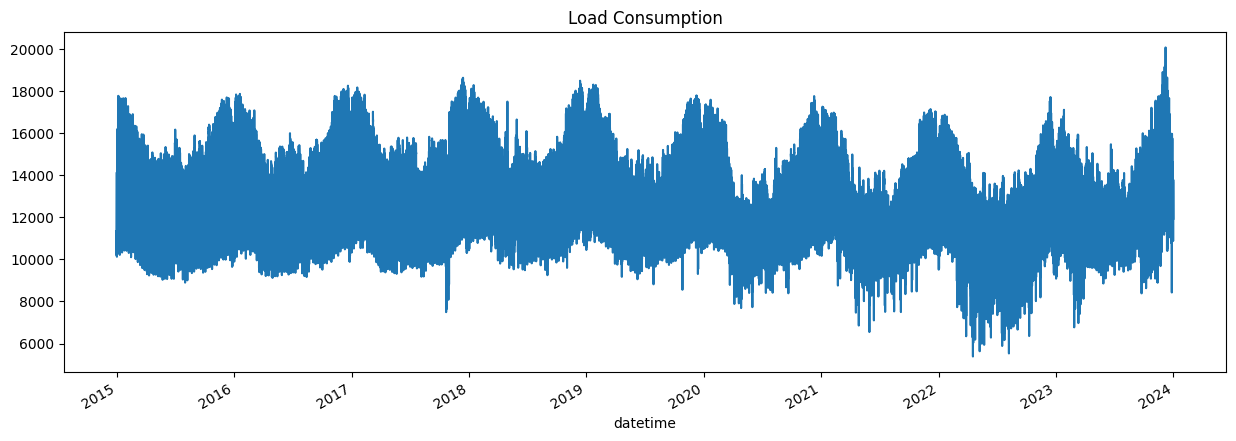

In [11]:
start_date = '2015-01-01'
end_date = '2023-12-31'

filtered_data = load_data.loc[start_date:end_date]
filtered_data['loadConsumption'].plot(
    style='-',
    figsize=(15, 5),
    color=color_pal[0],
    title='Load Consumption'
)

plt.savefig('Load_Consumption.png', dpi=300, bbox_inches='tight')

plt.show()

### Daily data

In [12]:
# Resample to daily data using sum
dailyLoad_data = filtered_data.groupby("date")["loadConsumption"].sum().reset_index()


In [13]:
#dailyLoad_data.set_index("date", inplace=True)

In [14]:
dailyLoad_data

,date,loadConsumption
0,2015-01-01,275667.0000
1,2015-01-02,319026.0000
2,2015-01-03,313131.0000
3,2015-01-04,296832.0000
4,2015-01-05,350937.0000
...,...,...
3282,2023-12-27,305610.2900
3283,2023-12-28,326312.3400
3284,2023-12-29,314575.3300
3285,2023-12-30,290563.1625


In [15]:
# Create lag features for the past 7 days
#for lag in range(1, 8):  # Lags for the past 7 days
#    dailyLoad_data[f'lag_{lag}'] = dailyLoad_data['loadConsumption'].shift(lag)

#Drop rows with NaN values created by shifting
#dailyLoad_data.dropna(inplace=True)

In [16]:
# Add rolling mean and standard deviation for the past 7 days
#dailyLoad_data['rolling_mean_7'] = dailyLoad_data['loadConsumption'].rolling(window=7).mean()
#dailyLoad_data['rolling_std_7'] = dailyLoad_data['loadConsumption'].rolling(window=7).std()

# Drop rows with NaN values created by rolling
#dailyLoad_data.dropna(inplace=True)

In [17]:
# weather data
weather_data_path = 'processed_data/weather.csv' 
weather_data = pd.read_csv(weather_data_path)

In [18]:
#weather_data.head()

In [19]:
weather_data["Date"] = pd.to_datetime(weather_data["Date"])

In [20]:
#weather_data.set_index("Date", inplace=True)

In [21]:
# Ensure 'Year' is an integer
weather_data["Year"] = weather_data["Year"].astype(int)

# Filter for Year >= 2015
weather_data = weather_data[weather_data["Year"] >= 2015]

In [22]:
weather_data

,Date,DailyPrecipitation,MaxHourlyPrecipitation,HDMaxPrecipitation,DailyMeanTemperature,HourlyMinTemperature,HDMinTemperature,HourlyMaxTemperature,HDMaxTemperature,DailyMeanWindspeed,MaxHourlyMeanWindspeed,HDMaxMeanWindspeed,MinHourlyMeanWindspeed,HDMinMeanWindspeed,Month,Year,Week,WeekKey,day_of_week
3287,2015-01-01,-0.1,-0.1,1,3.0,10,5,4.7,24,5.4,8.0,24,4.0,1,1,2015,1,201501,Thursday
3288,2015-01-02,4.3,1.7,3,7.3,44,1,10.1,8,6.1,9.0,2,4.0,20,1,2015,1,201501,Friday
3289,2015-01-03,1.5,0.5,10,3.8,26,17,5.9,1,3.3,5.0,7,1.0,17,1,2015,1,201501,Saturday
3290,2015-01-04,-0.1,-0.1,1,3.9,-3,21,8.0,13,2.4,3.0,11,2.0,1,1,2015,1,201501,Sunday
3291,2015-01-05,0.0,0.0,1,2.4,9,11,3.8,24,3.0,5.0,11,1.0,22,1,2015,2,201502,Monday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6950,2025-01-11,-0.1,-0.1,1,0.5,-45,8,5.8,14,1.5,3.0,14,0.0,7,1,2025,2,202502,Saturday
6951,2025-01-12,0.1,0.1,21,1.7,-6,22,6.0,14,1.2,2.0,5,1.0,1,1,2025,2,202502,Sunday
6952,2025-01-13,0.0,0.0,1,0.5,-33,5,5.2,14,2.2,4.0,13,1.0,1,1,2025,3,202503,Monday
6953,2025-01-14,0.1,0.1,20,2.8,-16,1,5.7,24,3.1,5.0,13,2.0,6,1,2025,3,202503,Tuesday


In [23]:
dailyLoad_data.head()

,date,loadConsumption
0,2015-01-01,275667.0
1,2015-01-02,319026.0
2,2015-01-03,313131.0
3,2015-01-04,296832.0
4,2015-01-05,350937.0


In [24]:
# Ensure 'date' columns are in datetime format
dailyLoad_data["date"] = pd.to_datetime(dailyLoad_data["date"])
weather_data["Date"] = pd.to_datetime(weather_data["Date"])

# Set index to 'date' for both DataFrames


# Merge without setting the index
merged_data = dailyLoad_data.merge(weather_data, left_on="date", right_on="Date", how="inner")

# Drop redundant date column if necessary
merged_data.drop(columns=["Date"], inplace=True)

In [25]:
merged_data.head()

,date,loadConsumption,DailyPrecipitation,MaxHourlyPrecipitation,HDMaxPrecipitation,DailyMeanTemperature,HourlyMinTemperature,HDMinTemperature,HourlyMaxTemperature,HDMaxTemperature,DailyMeanWindspeed,MaxHourlyMeanWindspeed,HDMaxMeanWindspeed,MinHourlyMeanWindspeed,HDMinMeanWindspeed,Month,Year,Week,WeekKey,day_of_week
0,2015-01-01,275667.0,-0.1,-0.1,1,3.0,10,5,4.7,24,5.4,8.0,24,4.0,1,1,2015,1,201501,Thursday
1,2015-01-02,319026.0,4.3,1.7,3,7.3,44,1,10.1,8,6.1,9.0,2,4.0,20,1,2015,1,201501,Friday
2,2015-01-03,313131.0,1.5,0.5,10,3.8,26,17,5.9,1,3.3,5.0,7,1.0,17,1,2015,1,201501,Saturday
3,2015-01-04,296832.0,-0.1,-0.1,1,3.9,-3,21,8.0,13,2.4,3.0,11,2.0,1,1,2015,1,201501,Sunday
4,2015-01-05,350937.0,0.0,0.0,1,2.4,9,11,3.8,24,3.0,5.0,11,1.0,22,1,2015,2,201502,Monday


### Monthly Data

In [26]:
nao_path = 'processed_data/nao.csv'

In [27]:
nao = pd.read_csv(nao_path)

In [28]:
nao["Year"] = nao["Year"].astype(int)

# Filter for Year >= 2015
nao = nao[nao["Year"] >= 2015]

In [29]:
nao

,Year,Month,NAO
108,2015,1,1.79
109,2015,2,1.32
110,2015,3,1.45
111,2015,4,0.73
112,2015,5,0.15
...,...,...,...
223,2024,8,0.63
224,2024,9,-1.43
225,2024,10,-0.38
226,2024,11,-0.23


In [30]:
nao["Year"] = nao["Year"].astype(int)
nao["Month"] = nao["Month"].astype(int)


### Quartal data

In [31]:
gdp_path = 'processed_data/GDP.csv'

In [32]:
gdp = pd.read_csv(gdp_path)

In [33]:
gdp["Year"] = gdp["Year"].astype(int)

# Filter for Year >= 2015
gdp = gdp[gdp["Year"] >= 2015]

In [34]:
gdp.head()

,Period,GDP,Year
36,2015-01-01,171938.0,2015
37,2015-04-01,174143.8,2015
38,2015-07-01,176415.0,2015
39,2015-10-01,176716.6,2015
40,2016-01-01,177498.0,2016


In [35]:
# Convert 'Period' column to datetime format
gdp["Period"] = pd.to_datetime(gdp["Period"])

# Generate daily date range covering the full period
daily_dates = pd.date_range(start=gdp["Period"].min(), end=gdp["Period"].max(), freq='D')

# Convert quarterly GDP to daily by forward-filling values
gdp_daily = pd.DataFrame({"date": daily_dates})
gdp_daily["GDP"] = gdp.set_index("Period")["GDP"].resample("D").ffill().values

### Half Year data

In [36]:
energyPrice_path = 'processed_data/energyPrice.csv'

In [37]:
energyPrice = pd.read_csv(energyPrice_path)

In [38]:
energyPrice["Year"] = energyPrice["Year"].astype(int)

# Filter for Year >= 2015
energyPrice = energyPrice[energyPrice["Year"] >= 2015]

In [39]:
energyPrice.head()

,Year,PriceComponents,Periods,NG_Household_LessThan_569m3_EuroPerM3,NG_Household_569to5687m3_EuroPerM3,NG_Household_MoreThan_5687m3_EuroPerM3,NG_NonHousehold_LessThan_28433m3_EuroPerM3,NG_NonHousehold_28433to284333m3_EuroPerM3,NG_NonHousehold_284333to2843332m3_EuroPerM3,NG_NonHousehold_2843332to28433324m3_EuroPerM3,...,Electricity_NonHousehold_20to500MWh_EuroPerKWh,Electricity_NonHousehold_500to2000MWh_EuroPerKWh,Electricity_NonHousehold_2000to20000MWh_EuroPerKWh,Electricity_NonHousehold_20000to70000MWh_EuroPerKWh,Electricity_NonHousehold_70000to150000MWh_EuroPerKWh,Electricity_NonHousehold_MoreThan_150000MWh_EuroPerKWh,AveragePrice_Electricity_Household,AveragePrice_Electricity_NonHousehold,AveragePrice_NaturalGas_Household,AveragePrice_NaturalGas_NonHousehold
18,2015,TotalPrice,2015 1e halfjaar,1.037,0.739,0.680,0.715,0.648,0.460,0.360,...,0.173,0.110,0.099,0.086,0.086,0.081,0.1604,0.122143,0.818667,0.4962
19,2015,TotalPrice,2015 2e halfjaar,1.312,0.784,0.678,0.719,0.670,0.379,0.312,...,0.128,0.103,0.097,0.077,0.081,0.078,0.1240,0.111143,0.924667,0.4690
20,2015,TotalPrice,2015,1.139,0.755,0.673,0.717,0.657,0.430,0.339,...,0.151,0.106,0.098,0.081,0.084,0.079,0.1400,0.116571,0.855667,0.4852
21,2016,TotalPrice,2016 1e halfjaar,1.063,0.762,0.698,0.750,0.684,0.453,0.303,...,0.168,0.105,0.093,0.079,0.074,0.070,0.1168,0.111143,0.841000,0.4808
22,2016,TotalPrice,2016 2e halfjaar,1.277,0.790,0.696,0.751,0.667,0.340,0.286,...,0.123,0.097,0.093,0.071,0.071,0.071,0.1080,0.100714,0.921000,0.4528


In [40]:
# Keep only rows where PriceComponents is "TotalPrice"
energyPrice = energyPrice[energyPrice["PriceComponents"] == "TotalPrice"]

In [41]:
import re

def clean_year(period):
    return re.sub(r"\D", "", period.split()[0])  # Remove non-numeric characters

# Apply cleaning to the Year part of "Periods"
energyPrice["Year"] = energyPrice["Periods"].apply(clean_year).astype(int)

# Now apply the original function safely
def convert_to_date(period):
    year = int(re.sub(r"\D", "", period.split()[0]))  # Remove any unwanted characters
    if "1e halfjaar" in period:  # First half-year
        return f"{year}-01-01"
    elif "2e halfjaar" in period:  # Second half-year
        return f"{year}-07-01"
    else:  # Full year entry
        return f"{year}-01-01"

# Apply function
energyPrice["Start_Date"] = energyPrice["Periods"].apply(convert_to_date)
energyPrice["Start_Date"] = pd.to_datetime(energyPrice["Start_Date"]) 

In [42]:
# Create an empty list to store expanded rows
expanded_rows = []

# Iterate through each row and expand to daily records
for _, row in energyPrice.iterrows():
    start_date = row["Start_Date"]
    end_date = start_date + pd.DateOffset(months=6) - pd.Timedelta(days=1)  # Define half-year range
    daily_range = pd.date_range(start=start_date, end=end_date, freq='D')  # Generate daily dates
    
    # Create a DataFrame with repeated daily values
    temp_df = pd.DataFrame({"date": daily_range})
    
    # Assign the corresponding price columns to each daily row
    for col in energyPrice.columns[3:-1]:  # Exclude "Year", "PriceComponents", "Periods", and "Start_Date"
        temp_df[col] = row[col]  
    
    expanded_rows.append(temp_df)  # Append expanded rows

# Concatenate all daily records into a single DataFrame
daily_energy_price = pd.concat(expanded_rows, ignore_index=True)

In [43]:
daily_energy_price

,date,NG_Household_LessThan_569m3_EuroPerM3,NG_Household_569to5687m3_EuroPerM3,NG_Household_MoreThan_5687m3_EuroPerM3,NG_NonHousehold_LessThan_28433m3_EuroPerM3,NG_NonHousehold_28433to284333m3_EuroPerM3,NG_NonHousehold_284333to2843332m3_EuroPerM3,NG_NonHousehold_2843332to28433324m3_EuroPerM3,NG_NonHousehold_MoreThan_28433324m3_EuroPerM3,Electricity_Household_LessThan_1MWh_EuroPerKWh,...,Electricity_NonHousehold_20to500MWh_EuroPerKWh,Electricity_NonHousehold_500to2000MWh_EuroPerKWh,Electricity_NonHousehold_2000to20000MWh_EuroPerKWh,Electricity_NonHousehold_20000to70000MWh_EuroPerKWh,Electricity_NonHousehold_70000to150000MWh_EuroPerKWh,Electricity_NonHousehold_MoreThan_150000MWh_EuroPerKWh,AveragePrice_Electricity_Household,AveragePrice_Electricity_NonHousehold,AveragePrice_NaturalGas_Household,AveragePrice_NaturalGas_NonHousehold
0,2015-01-01,1.037,0.739,0.680,0.715,0.648,0.460,0.360,0.298,-0.025,...,0.173,0.11,0.099,0.086,0.086,0.081,0.1604,0.122143,0.818667,0.4962
1,2015-01-02,1.037,0.739,0.680,0.715,0.648,0.460,0.360,0.298,-0.025,...,0.173,0.11,0.099,0.086,0.086,0.081,0.1604,0.122143,0.818667,0.4962
2,2015-01-03,1.037,0.739,0.680,0.715,0.648,0.460,0.360,0.298,-0.025,...,0.173,0.11,0.099,0.086,0.086,0.081,0.1604,0.122143,0.818667,0.4962
3,2015-01-04,1.037,0.739,0.680,0.715,0.648,0.460,0.360,0.298,-0.025,...,0.173,0.11,0.099,0.086,0.086,0.081,0.1604,0.122143,0.818667,0.4962
4,2015-01-05,1.037,0.739,0.680,0.715,0.648,0.460,0.360,0.298,-0.025,...,0.173,0.11,0.099,0.086,0.086,0.081,0.1604,0.122143,0.818667,0.4962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5095,2024-06-26,1.924,1.588,1.417,1.594,1.467,0.849,0.736,0.555,-0.041,...,0.324,0.24,0.232,0.201,0.240,0.174,0.2188,0.255286,1.643000,1.0402
5096,2024-06-27,1.924,1.588,1.417,1.594,1.467,0.849,0.736,0.555,-0.041,...,0.324,0.24,0.232,0.201,0.240,0.174,0.2188,0.255286,1.643000,1.0402
5097,2024-06-28,1.924,1.588,1.417,1.594,1.467,0.849,0.736,0.555,-0.041,...,0.324,0.24,0.232,0.201,0.240,0.174,0.2188,0.255286,1.643000,1.0402
5098,2024-06-29,1.924,1.588,1.417,1.594,1.467,0.849,0.736,0.555,-0.041,...,0.324,0.24,0.232,0.201,0.240,0.174,0.2188,0.255286,1.643000,1.0402


### Yearly Data

In [44]:
elecBalance_path = 'processed_data/elecBalance.csv'

In [45]:
elecBalance = pd.read_csv(elecBalance_path)

In [46]:
# Convert all columns from PJ to MWh (1 PJ = 277,778 MWh)
conversion_factor = 277778

# Identify columns containing 'PJ' to convert
columns_to_convert = [col for col in elecBalance.columns if '(PJ)' in col]

# Apply conversion and rename columns
for col in columns_to_convert:
    elecBalance[col.replace("(PJ)", "(MWh)")] = elecBalance[col] * conversion_factor

# Drop original columns
elecBalance.drop(columns=columns_to_convert, inplace=True)

In [47]:
### consumption of electricity by orginal source?

In [48]:
elecBalance.head()

,Year,Commercial and public services (MWh),"Electricity, CHP and heat plants (MWh)",Exports (MWh),Imports (MWh),Industry (MWh),"Oil refineries, transformation (MWh)",Other final consumption (MWh),Production (MWh),Residential (MWh),Total energy supply (MWh),Total final consumption (MWh),Transport (MWh)
0,2006,3.462703e+07,9.883308e+07,-5.887005e+06,2.734602e+07,4.150914e+07,0,5.745005e+06,0,2.208102e+07,2.145902e+07,1.055762e+08,1.614001e+06
1,2007,3.541703e+07,1.051661e+08,-5.480005e+06,2.308902e+07,4.217803e+07,0,6.298005e+06,0,2.226802e+07,1.760901e+07,1.077511e+08,1.590001e+06
2,2008,3.588903e+07,1.075521e+08,-9.116007e+06,2.496702e+07,4.188160e+07,0,6.528006e+06,0,2.250102e+07,1.585101e+07,1.084237e+08,1.624002e+06
3,2009,3.654703e+07,1.136901e+08,-1.056101e+07,1.545201e+07,3.647583e+07,0,7.083006e+06,0,2.287202e+07,4.891004e+06,1.046559e+08,1.678001e+06
4,2010,3.676603e+07,1.192691e+08,-1.280801e+07,1.558301e+07,3.910208e+07,0,7.024006e+06,0,2.299402e+07,2.775003e+06,1.076421e+08,1.756001e+06


In [49]:
elecBalance["Year"] = elecBalance["Year"].astype(int)

# Filter for Year >= 2015
elecBalance = elecBalance[elecBalance["Year"] >= 2015]

In [50]:
population_path = 'processed_data/populationNL.csv'

In [51]:
populationNL = pd.read_csv(population_path)

In [52]:
populationNL["Year"] = populationNL["Year"].astype(int)

# Filter for Year >= 2015
populationNL = populationNL[populationNL["Year"] >= 2015]

In [53]:
populationNL

,Year,Population
9,2015,"16,90"
10,2016,"16,98"
11,2017,"17,08"
12,2018,"17,18"
13,2019,"17,28"
14,2020,"17,41"
15,2021,"17,48"
16,2022,"17,59"
17,2023,"17,81"


In [54]:
res_path = 'processed_data/renwableEnergy.csv'

In [55]:
rEnergy = pd.read_csv(res_path)

In [56]:
# Convert all columns from TJ to MWh (1 TJ = 277.78 MWh)
conversion_factor = 277.78

# Identify columns containing energy values (assuming all except "Year")
columns_to_convert = [col for col in rEnergy.columns if col != "Year"]

# Apply conversion and rename columns
for col in columns_to_convert:
    rEnergy[col + " (MWh)"] = rEnergy[col] * conversion_factor

# Drop original columns
rEnergy.drop(columns=columns_to_convert, inplace=True)


In [57]:
rEnergy["Year"] = rEnergy["Year"].astype(int)

# Filter for Year >= 2015
rEnergy = rEnergy[rEnergy["Year"] >= 2015]

In [58]:
### production of renewable energy per source?

In [59]:
rEnergy

,Year,GeothermalHeat (MWh),AmbientAirHeat (MWh),TotalGeothermal&GroundEnergy (MWh),TotalBiomass (MWh),TotalRes(excl.Stat.Transfer) (MWh),TotalRes(incl.Stat.Transfer) (MWh),Totaal windenergie (MWh),TotalSolarEnergy (MWh),Total Including Non-Renewable (MWh),Hydropower (MWh),OnshoreWindEnergy (MWh),OffshoreWindEnergy (MWh),SolarPower (MWh),SolarThermalEnergy (MWh)
9,2015,1009452.52,560837.82,1689457.96,21863230.46,32553593.76,32553593.76,6916722.00,1424178.06,5.684820e+08,98611.90,5881713.72,1035286.06,1108619.98,315835.86
10,2016,1070841.90,731950.30,1860848.22,20963778.82,33938327.06,33938327.06,8363955.80,1920293.14,5.809183e+08,97500.78,6041159.44,2322796.36,1601957.26,318613.66
11,2017,1133620.18,980285.62,1979738.06,22786015.62,38004470.70,38004470.70,9641743.80,2522242.40,5.846283e+08,94167.42,6266716.80,3375027.00,2204462.08,317780.32
12,2018,1217509.74,1296677.04,2253906.92,25712983.48,43418125.12,43418125.12,10029524.68,4030587.80,5.878072e+08,94445.20,6578108.18,3451694.28,3709474.12,321113.68
13,2019,1309732.70,1713069.26,2855300.62,30123852.10,51287076.96,51287076.96,10773419.52,5726990.26,5.771168e+08,92778.52,7428670.54,3344748.98,5399209.86,327780.40
14,2020,1415844.66,2225573.36,3133913.96,33456934.32,61949106.70,75599215.90,13948722.70,9091461.62,5.400543e+08,90000.72,8962293.92,4986428.78,8764792.34,326669.28
15,2021,1533345.60,2918634.46,3290859.66,35205837.20,72131410.38,72131410.38,18998485.32,11627315.24,5.567658e+08,90556.28,10454250.30,8544235.02,11303979.32,323335.92
16,2022,1662235.52,3941975.98,3550861.74,30623578.32,76588390.48,76588390.48,21404060.12,16981246.96,5.139616e+08,86667.36,12956770.32,8447289.80,16656799.92,324447.04
17,2023,1849181.46,5240875.26,3737529.90,29222456.00,85044291.46,85044291.46,26854103.72,19904881.46,4.957576e+08,84445.12,15767348.36,11086755.36,19578212.18,326669.28


In [60]:
YearlyFinalCons_path = 'processed_data/yearlyfinalConsPerSource.csv'

In [61]:
YearlyFinalCons = pd.read_csv(YearlyFinalCons_path)

In [62]:
# Convert all columns from PJ to MWh (1 PJ = 277,778 MWh)
conversion_factor = 277778

# Identify columns containing energy values (assuming all except "Year")
columns_to_convert = [col for col in YearlyFinalCons.columns if col != "Year"]

# Apply conversion and rename columns
for col in columns_to_convert:
    YearlyFinalCons[col + " (MWh)"] = YearlyFinalCons[col] * conversion_factor

# Drop the original PJ columns
YearlyFinalCons.drop(columns=columns_to_convert, inplace=True)

In [63]:
 YearlyFinalCons["Year"] = YearlyFinalCons["Year"].astype(int)

# Filter for Year >= 2015
YearlyFinalCons = YearlyFinalCons[YearlyFinalCons["Year"] >= 2015]


In [64]:
### Final consumption of each source

In [65]:
YearlyFinalCons

,Year,"Crude, NGL and feedstocks (MWh)",Electricity (MWh),Heat (MWh),Natural gas (MWh),Oil products (MWh),Renewables and waste (MWh),Total (MWh)
9,2015,2.561924e+07,1.036768e+08,2.634479e+07,2.247547e+08,2.478791e+08,1.408313e+07,6.483023e+08
10,2016,2.678760e+07,1.046485e+08,2.579003e+07,2.300846e+08,2.593781e+08,1.352092e+07,6.668403e+08
11,2017,2.518568e+07,1.058181e+08,2.451098e+07,2.331301e+08,2.690828e+08,1.489403e+07,6.800887e+08
12,2018,2.032454e+07,1.078638e+08,2.330076e+07,2.279023e+08,2.674885e+08,1.868505e+07,6.720822e+08
13,2019,1.707783e+07,1.076402e+08,2.414097e+07,2.241073e+08,2.539378e+08,2.073531e+07,6.545552e+08
14,2020,1.891350e+07,1.063510e+08,2.208057e+07,2.136106e+08,2.505897e+08,1.998465e+07,6.366558e+08
15,2021,1.667307e+07,1.067559e+08,2.330489e+07,2.300143e+08,2.478729e+08,2.081999e+07,6.502021e+08
16,2022,1.741601e+07,1.037859e+08,2.127010e+07,1.799323e+08,2.281547e+08,1.998440e+07,5.757271e+08


In [66]:
merged_Yearly_data = pd.merge(populationNL, rEnergy, on=["Year"], how="inner")

In [67]:
merged_Yearly_data

,Year,Population,GeothermalHeat (MWh),AmbientAirHeat (MWh),TotalGeothermal&GroundEnergy (MWh),TotalBiomass (MWh),TotalRes(excl.Stat.Transfer) (MWh),TotalRes(incl.Stat.Transfer) (MWh),Totaal windenergie (MWh),TotalSolarEnergy (MWh),Total Including Non-Renewable (MWh),Hydropower (MWh),OnshoreWindEnergy (MWh),OffshoreWindEnergy (MWh),SolarPower (MWh),SolarThermalEnergy (MWh)
0,2015,"16,90",1009452.52,560837.82,1689457.96,21863230.46,32553593.76,32553593.76,6916722.00,1424178.06,5.684820e+08,98611.90,5881713.72,1035286.06,1108619.98,315835.86
1,2016,"16,98",1070841.90,731950.30,1860848.22,20963778.82,33938327.06,33938327.06,8363955.80,1920293.14,5.809183e+08,97500.78,6041159.44,2322796.36,1601957.26,318613.66
2,2017,"17,08",1133620.18,980285.62,1979738.06,22786015.62,38004470.70,38004470.70,9641743.80,2522242.40,5.846283e+08,94167.42,6266716.80,3375027.00,2204462.08,317780.32
3,2018,"17,18",1217509.74,1296677.04,2253906.92,25712983.48,43418125.12,43418125.12,10029524.68,4030587.80,5.878072e+08,94445.20,6578108.18,3451694.28,3709474.12,321113.68
4,2019,"17,28",1309732.70,1713069.26,2855300.62,30123852.10,51287076.96,51287076.96,10773419.52,5726990.26,5.771168e+08,92778.52,7428670.54,3344748.98,5399209.86,327780.40
5,2020,"17,41",1415844.66,2225573.36,3133913.96,33456934.32,61949106.70,75599215.90,13948722.70,9091461.62,5.400543e+08,90000.72,8962293.92,4986428.78,8764792.34,326669.28
6,2021,"17,48",1533345.60,2918634.46,3290859.66,35205837.20,72131410.38,72131410.38,18998485.32,11627315.24,5.567658e+08,90556.28,10454250.30,8544235.02,11303979.32,323335.92
7,2022,"17,59",1662235.52,3941975.98,3550861.74,30623578.32,76588390.48,76588390.48,21404060.12,16981246.96,5.139616e+08,86667.36,12956770.32,8447289.80,16656799.92,324447.04
8,2023,"17,81",1849181.46,5240875.26,3737529.90,29222456.00,85044291.46,85044291.46,26854103.72,19904881.46,4.957576e+08,84445.12,15767348.36,11086755.36,19578212.18,326669.28


In [68]:
merged_Yearly_data.columns

Index(['Year', 'Population', 'GeothermalHeat (MWh)', 'AmbientAirHeat (MWh)',
       'TotalGeothermal&GroundEnergy (MWh)', 'TotalBiomass (MWh)',
       'TotalRes(excl.Stat.Transfer) (MWh)',
       'TotalRes(incl.Stat.Transfer) (MWh)', 'Totaal windenergie (MWh)',
       'TotalSolarEnergy (MWh)', 'Total Including Non-Renewable (MWh)',
       'Hydropower (MWh)', 'OnshoreWindEnergy (MWh)',
       'OffshoreWindEnergy (MWh)', 'SolarPower (MWh)',
       'SolarThermalEnergy (MWh)'],
      dtype='object')

## Merging All Data on Daily basis

In [69]:
# Convert date column to datetime format in daily data
merged_data['date'] = pd.to_datetime(merged_data['date'])

# Extract year and month for merging
merged_data['Year'] = merged_data['date'].dt.year
merged_data['Month'] = merged_data['date'].dt.month

# Merge daily with monthly data on Year and Month
all_data = merged_data.merge(nao, on=['Year', 'Month'], how='inner', suffixes=('', '_monthly'))

# Merge the result with yearly data on Year
all_data = all_data.merge(merged_Yearly_data, on=['Year'], how='inner', suffixes=('', '_yearly'))

all_data = pd.merge(all_data, daily_energy_price, on=["date"], how="inner")
all_data = pd.merge(all_data, gdp_daily, on=["date"], how="inner")

In [70]:
all_data

,date,loadConsumption,DailyPrecipitation,MaxHourlyPrecipitation,HDMaxPrecipitation,DailyMeanTemperature,HourlyMinTemperature,HDMinTemperature,HourlyMaxTemperature,HDMaxTemperature,...,Electricity_NonHousehold_500to2000MWh_EuroPerKWh,Electricity_NonHousehold_2000to20000MWh_EuroPerKWh,Electricity_NonHousehold_20000to70000MWh_EuroPerKWh,Electricity_NonHousehold_70000to150000MWh_EuroPerKWh,Electricity_NonHousehold_MoreThan_150000MWh_EuroPerKWh,AveragePrice_Electricity_Household,AveragePrice_Electricity_NonHousehold,AveragePrice_NaturalGas_Household,AveragePrice_NaturalGas_NonHousehold,GDP
0,2015-01-01,275667.0000,-0.1,-0.1,1,3.0,10,5,4.7,24,...,0.110,0.099,0.086,0.086,0.081,0.1604,0.122143,0.818667,0.4962,171938.0
1,2015-01-01,275667.0000,-0.1,-0.1,1,3.0,10,5,4.7,24,...,0.106,0.098,0.081,0.084,0.079,0.1400,0.116571,0.855667,0.4852,171938.0
2,2015-01-02,319026.0000,4.3,1.7,3,7.3,44,1,10.1,8,...,0.110,0.099,0.086,0.086,0.081,0.1604,0.122143,0.818667,0.4962,171938.0
3,2015-01-02,319026.0000,4.3,1.7,3,7.3,44,1,10.1,8,...,0.106,0.098,0.081,0.084,0.079,0.1400,0.116571,0.855667,0.4852,171938.0
4,2015-01-03,313131.0000,1.5,0.5,10,3.8,26,17,5.9,1,...,0.110,0.099,0.086,0.086,0.081,0.1604,0.122143,0.818667,0.4962,171938.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4913,2023-12-27,305610.2900,3.4,1.3,8,7.0,6,2,10.7,24,...,0.251,0.278,0.217,0.291,0.237,0.2128,0.277143,1.671333,1.0218,272030.5
4914,2023-12-28,326312.3400,0.8,0.6,23,10.9,100,24,11.5,13,...,0.251,0.278,0.217,0.291,0.237,0.2128,0.277143,1.671333,1.0218,272030.5
4915,2023-12-29,314575.3300,3.8,1.4,16,9.3,55,18,11.4,13,...,0.251,0.278,0.217,0.291,0.237,0.2128,0.277143,1.671333,1.0218,272030.5
4916,2023-12-30,290563.1625,-0.1,-0.1,1,8.1,55,7,9.7,18,...,0.251,0.278,0.217,0.291,0.237,0.2128,0.277143,1.671333,1.0218,272030.5


In [71]:
all_data.columns

Index(['date', 'loadConsumption', 'DailyPrecipitation',
       'MaxHourlyPrecipitation', 'HDMaxPrecipitation', 'DailyMeanTemperature',
       'HourlyMinTemperature', 'HDMinTemperature', 'HourlyMaxTemperature',
       'HDMaxTemperature', 'DailyMeanWindspeed', 'MaxHourlyMeanWindspeed',
       'HDMaxMeanWindspeed', 'MinHourlyMeanWindspeed', 'HDMinMeanWindspeed',
       'Month', 'Year', 'Week', 'WeekKey', 'day_of_week', 'NAO', 'Population',
       'GeothermalHeat (MWh)', 'AmbientAirHeat (MWh)',
       'TotalGeothermal&GroundEnergy (MWh)', 'TotalBiomass (MWh)',
       'TotalRes(excl.Stat.Transfer) (MWh)',
       'TotalRes(incl.Stat.Transfer) (MWh)', 'Totaal windenergie (MWh)',
       'TotalSolarEnergy (MWh)', 'Total Including Non-Renewable (MWh)',
       'Hydropower (MWh)', 'OnshoreWindEnergy (MWh)',
       'OffshoreWindEnergy (MWh)', 'SolarPower (MWh)',
       'SolarThermalEnergy (MWh)', 'NG_Household_LessThan_569m3_EuroPerM3',
       'NG_Household_569to5687m3_EuroPerM3',
       'NG_Househ

In [72]:
coloumn_to_keep = ['date', 'loadConsumption', 'DailyPrecipitation',
       'MaxHourlyPrecipitation', 'HDMaxPrecipitation', 'DailyMeanTemperature',
       'HourlyMinTemperature', 'HDMinTemperature', 'HourlyMaxTemperature',
       'HDMaxTemperature', 'DailyMeanWindspeed', 'MaxHourlyMeanWindspeed',
       'HDMaxMeanWindspeed', 'MinHourlyMeanWindspeed', 'HDMinMeanWindspeed',
       'Month', 'Year', 'Week', 'day_of_week', 'NAO', 'Population',
       'TotalBiomass (MWh)',
       'TotalRes(incl.Stat.Transfer) (MWh)', 'Totaal windenergie (MWh)',
       'TotalSolarEnergy (MWh)', 'Total Including Non-Renewable (MWh)',
       'AveragePrice_Electricity_Household',
       'AveragePrice_Electricity_NonHousehold',
       'AveragePrice_NaturalGas_Household',
       'AveragePrice_NaturalGas_NonHousehold', 'GDP']

In [73]:
# Identify non-numeric columns
non_numeric_cols = all_data.select_dtypes(include=['object']).columns
print("Categorical Columns:", non_numeric_cols)


Categorical Columns: Index(['day_of_week', 'Population'], dtype='object')


In [74]:
all_data["Population"] = all_data["Population"].str.replace(',', '').astype(float)

In [75]:
all_data = all_data[coloumn_to_keep]

In [76]:
from sklearn.preprocessing import LabelEncoder

# Label encode 'day_of_week'
label_encoder = LabelEncoder()
all_data["day_of_week"] = label_encoder.fit_transform(all_data["day_of_week"])

C:\Users\mahmo\AppData\Local\Temp\ipykernel_5816\1803951313.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data["day_of_week"] = label_encoder.fit_transform(all_data["day_of_week"])


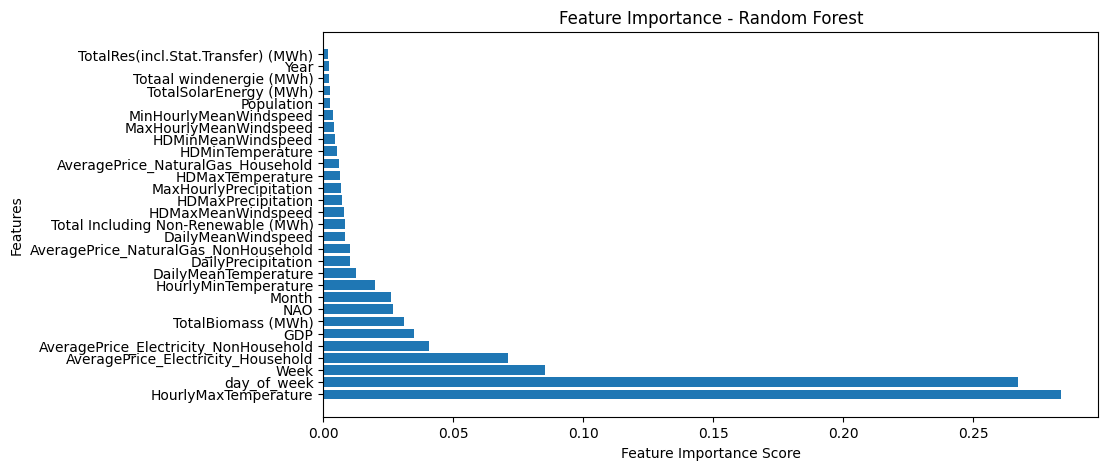

In [77]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Define features and target
X = all_data.drop(columns=["loadConsumption", 'date'])  # Excluding target variable
y = all_data["loadConsumption"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Get feature importance
importances = rf_model.feature_importances_
feature_names = X.columns

# Visualize importance
import matplotlib.pyplot as plt
import pandas as pd

feat_importance_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
feat_importance_df = feat_importance_df.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 5))
plt.barh(feat_importance_df["Feature"], feat_importance_df["Importance"])
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance - Random Forest")
plt.show()

In [78]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# Define the feature set (excluding target variable)
X = all_data.drop(columns=["loadConsumption", 'date']) 

# Compute VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display results
print(vif_data.sort_values(by="VIF", ascending=False))


                                  Feature           VIF
14                                   Year  1.671535e+06
25  AveragePrice_Electricity_NonHousehold  2.464378e+03
22                 TotalSolarEnergy (MWh)  1.523072e+03
27   AveragePrice_NaturalGas_NonHousehold  1.234620e+03
18                             Population  6.989048e+02
21               Totaal windenergie (MWh)  6.396509e+02
20     TotalRes(incl.Stat.Transfer) (MWh)  5.700605e+02
23    Total Including Non-Renewable (MWh)  5.309435e+02
26      AveragePrice_NaturalGas_Household  1.891452e+02
24     AveragePrice_Electricity_Household  1.200415e+02
3                    DailyMeanTemperature  9.242905e+01
19                     TotalBiomass (MWh)  9.236606e+01
28                                    GDP  8.308379e+01
6                    HourlyMaxTemperature  4.436229e+01
4                    HourlyMinTemperature  1.846160e+01
8                      DailyMeanWindspeed  1.821906e+01
13                                  Month  1.768

In [79]:
# Drop low-importance features
low_importance_features = [
    "HDMinMeanWindspeed", "HDMaxMeanWindspeed", "HDMaxPrecipitation",
    "HDMinTemperature", "HDMaxTemperature", "NAO"
]

all_data = all_data.drop(columns=low_importance_features)


In [80]:
# Save the merged dataset
merged_file_path = "merged_data_granualityBased/_data_(daily).csv"
all_data.to_csv(merged_file_path, index=False)